En este código se encuentra el paso a paso de nuestro proyecto final del máster, en el que se extraen datos de distintas API's para lograr compilar datos y lograr armar un modelo para predecir la probabilidad de que USA entre en recesión económica

In [1]:
import requests
import pandas as pd
from fred_key import fred_key
import openpyxl
import numpy as np
import yfinance as yf
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import joblib
from sklearn.pipeline import Pipeline
from catboost import CatBoostRegressor, Pool

from sklearn.preprocessing import MinMaxScaler

from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV, train_test_split

from sklearn.metrics import confusion_matrix
import warnings
import lightgbm as lgb

# Ignorar todos los warnings
warnings.filterwarnings("ignore")




In [2]:
today_date = datetime.today().strftime('%Y-%m-%d')

In [3]:
api_key = fred_key

# Define the FRED API endpoint
base_url = 'https://api.stlouisfed.org/fred/'

# Define indicators and their corresponding FRED series IDs
indicators = {
   'VIX': 'VIXCLS', #Daily #1976-06-01
   'Unemployment': 'UNRATE', #Montlhy #1948-01-01
#    'S&P500': 'SP500', #Daily #1920
   'Interest_Rates': 'FEDFUNDS', #Montlhy #1954-07-01
   'YIC':'T10Y2Y', #Daily #1976-06-01 
   'M2 MONEY STOCK': 'M2SL',
   'PER CAPITA CONSUMPTION': 'PCEPILFE',
   'CONSUMER PRICE INDEX': 'CPIAUCNS',
    'USREC_1' : 'USREC', #Monthly #1854-12-01,
}

# Assign common parameters
start_date = '1990-01-01'

end_date = today_date
#
file_type = 'json'
ts_frequency = 'm'

# Fetch data for each indicator
data_frames = {}
for indicator, series_id in indicators.items():
    obs_params = {
        'series_id': series_id,
        'api_key': api_key,
        'file_type': file_type,
        'observation_start': start_date,
        'observation_end': end_date,
        'frequency': ts_frequency,
    }

    # Make request to FRED API
    response = requests.get(base_url + 'series/observations', params=obs_params)

    # Create DataFrame for each indicator
    if response.status_code == 200:
        res_data = response.json()
        obs_data = pd.DataFrame(res_data['observations'])
        obs_data['date'] = pd.to_datetime(obs_data['date'])
        obs_data.set_index('date', inplace=True)
        obs_data['value'] = obs_data['value']
        data_frames[indicator] = obs_data
    else:
        print(f'Failed to retrieve data for {indicator}. Status code:', response.status_code)

Para descargar los datos desde la API de la FRED:

In [4]:
# Display the modified DataFrames for each indicator
for indicator, df in data_frames.items():
    # Create a modified DataFrame by dropping specified columns
    modified_df = df.drop(['realtime_start', 'realtime_end'], axis=1)
    
    # Store the modified DataFrame in the dictionary
    data_frames[indicator] = modified_df


# Concatenar los DataFrames
combined_df = pd.concat(data_frames.values(), axis=1, keys=data_frames.keys())

# Eliminar el nivel de nombre 'value' de las columnas
combined_df.columns = combined_df.columns.droplevel(1)

combined_df['USREC'] = combined_df['USREC_1']

combined_df = combined_df.drop('USREC_1', axis = 1)

# Reset Index
combined_df.reset_index(inplace=True)


combined_df.head(5)

,date,VIX,Unemployment,Interest_Rates,YIC,M2 MONEY STOCK,PER CAPITA CONSUMPTION,CONSUMER PRICE INDEX,USREC
0,1990-01-01,23.35,5.4,8.23,0.12,3166.8,59.181,127.4,0
1,1990-02-01,23.26,5.3,8.24,0.10,3179.2,59.468,128.0,0
2,1990-03-01,20.06,5.2,8.28,-0.04,3190.1,59.754,128.7,0
3,1990-04-01,21.40,5.4,8.26,0.06,3201.6,59.932,128.9,0
4,1990-05-01,18.10,5.4,8.18,0.12,3200.6,60.115,129.2,0


Eliminar el mes actual, ya que no se cuenta con esa información

In [5]:
combined_df = combined_df[:-1]

combined_df

,date,VIX,Unemployment,Interest_Rates,YIC,M2 MONEY STOCK,PER CAPITA CONSUMPTION,CONSUMER PRICE INDEX,USREC
0,1990-01-01,23.35,5.4,8.23,0.12,3166.8,59.181,127.4,0
1,1990-02-01,23.26,5.3,8.24,0.10,3179.2,59.468,128.0,0
2,1990-03-01,20.06,5.2,8.28,-0.04,3190.1,59.754,128.7,0
3,1990-04-01,21.40,5.4,8.26,0.06,3201.6,59.932,128.9,0
4,1990-05-01,18.10,5.4,8.18,0.12,3200.6,60.115,129.2,0
...,...,...,...,...,...,...,...,...,...
409,2024-02-01,13.98,3.9,5.33,-0.34,20748.6,121.224,310.326,0
410,2024-03-01,13.79,3.8,5.33,-0.38,20842.1,121.629,312.332,0
411,2024-04-01,16.14,3.9,5.33,-0.33,20870.2,121.944,313.548,0
412,2024-05-01,13.06,4.0,5.33,-0.37,20963.4,122.045,314.069,0


In [6]:
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 414 entries, 0 to 413
Data columns (total 9 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   date                    414 non-null    datetime64[ns]
 1   VIX                     414 non-null    object        
 2   Unemployment            413 non-null    object        
 3   Interest_Rates          414 non-null    object        
 4   YIC                     414 non-null    object        
 5   M2 MONEY STOCK          413 non-null    object        
 6   PER CAPITA CONSUMPTION  413 non-null    object        
 7   CONSUMER PRICE INDEX    413 non-null    object        
 8   USREC                   413 non-null    object        
dtypes: datetime64[ns](1), object(8)
memory usage: 29.2+ KB


In [7]:

columnas = combined_df.columns[1:]

# Iterar sobre cada columna seleccionada y convertir los valores numéricos a tipo float64
for col in columnas:
    combined_df[col] = pd.to_numeric(combined_df[col], errors='coerce')

combined_df.head(5)



,date,VIX,Unemployment,Interest_Rates,YIC,M2 MONEY STOCK,PER CAPITA CONSUMPTION,CONSUMER PRICE INDEX,USREC
0,1990-01-01,23.35,5.4,8.23,0.12,3166.8,59.181,127.4,0.0
1,1990-02-01,23.26,5.3,8.24,0.10,3179.2,59.468,128.0,0.0
2,1990-03-01,20.06,5.2,8.28,-0.04,3190.1,59.754,128.7,0.0
3,1990-04-01,21.40,5.4,8.26,0.06,3201.6,59.932,128.9,0.0
4,1990-05-01,18.10,5.4,8.18,0.12,3200.6,60.115,129.2,0.0


In [8]:
total_nans = combined_df.isna().sum().sum()

In [9]:
# Identificar las columnas a procesar
columns_to_process = combined_df.columns.difference(['date', 'USREC'])

# Calcular el factor promedio para cada columna
factors = {}
for col in columns_to_process:
    factors[col] = (combined_df[col] / combined_df[col].shift(1)).mean(skipna=True)

# Rellenar los valores NaN usando el método ffill y multiplicar por el factor solo si hay NaN en la columna
for col in columns_to_process:
    if combined_df[col].isna().any():
        combined_df[col] = combined_df[col].fillna(method='ffill') * factors[col]

In [10]:
combined_df

,date,VIX,Unemployment,Interest_Rates,YIC,M2 MONEY STOCK,PER CAPITA CONSUMPTION,CONSUMER PRICE INDEX,USREC
0,1990-01-01,23.35,5.414391,8.23,0.12,3181.408919,59.285105,127.680050,0.0
1,1990-02-01,23.26,5.314125,8.24,0.10,3193.866122,59.572610,128.281369,0.0
2,1990-03-01,20.06,5.213858,8.28,-0.04,3204.816406,59.859113,128.982908,0.0
3,1990-04-01,21.40,5.414391,8.26,0.06,3216.369457,60.037426,129.183347,0.0
4,1990-05-01,18.10,5.414391,8.18,0.12,3215.364844,60.220748,129.484007,0.0
...,...,...,...,...,...,...,...,...,...
409,2024-02-01,13.98,3.910394,5.33,-0.34,20844.316378,121.437245,311.008157,0.0
410,2024-03-01,13.79,3.810127,5.33,-0.38,20938.247707,121.842957,313.018566,0.0
411,2024-04-01,16.14,3.910394,5.33,-0.33,20966.477336,122.158511,314.237239,0.0
412,2024-05-01,13.06,4.010660,5.33,-0.37,21060.107282,122.259689,314.759385,0.0


In [11]:
combined_df = combined_df.iloc[:-1]

In [12]:
combined_df.to_excel('dataframe.xlsx', index = False)

In [13]:

# Convertir la columna de fechas a una representación numérica antes de la división de datos
combined_df['date'] = combined_df['date'].astype('int64')

scaler = MinMaxScaler()

# Normalizar el DataFrame excepto la columna 'date'
columns_to_normalize = combined_df.columns.difference(['date','USREC'])  # Excluir la columna 'date'
combined_df[columns_to_normalize] = scaler.fit_transform(combined_df[columns_to_normalize])

X = combined_df.drop('USREC', axis=1)
y = combined_df['USREC']

<Figure size 1200x800 with 0 Axes>

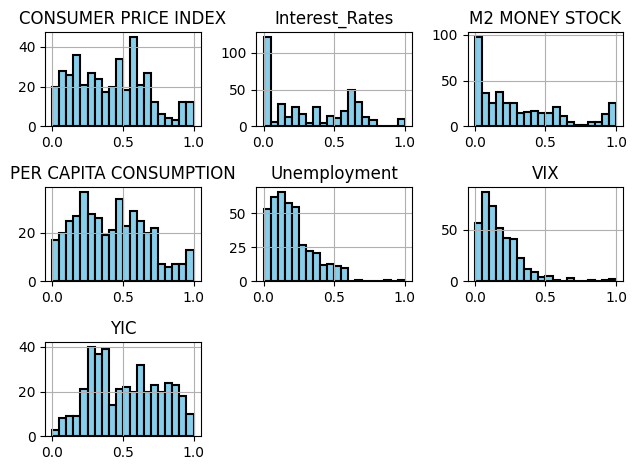

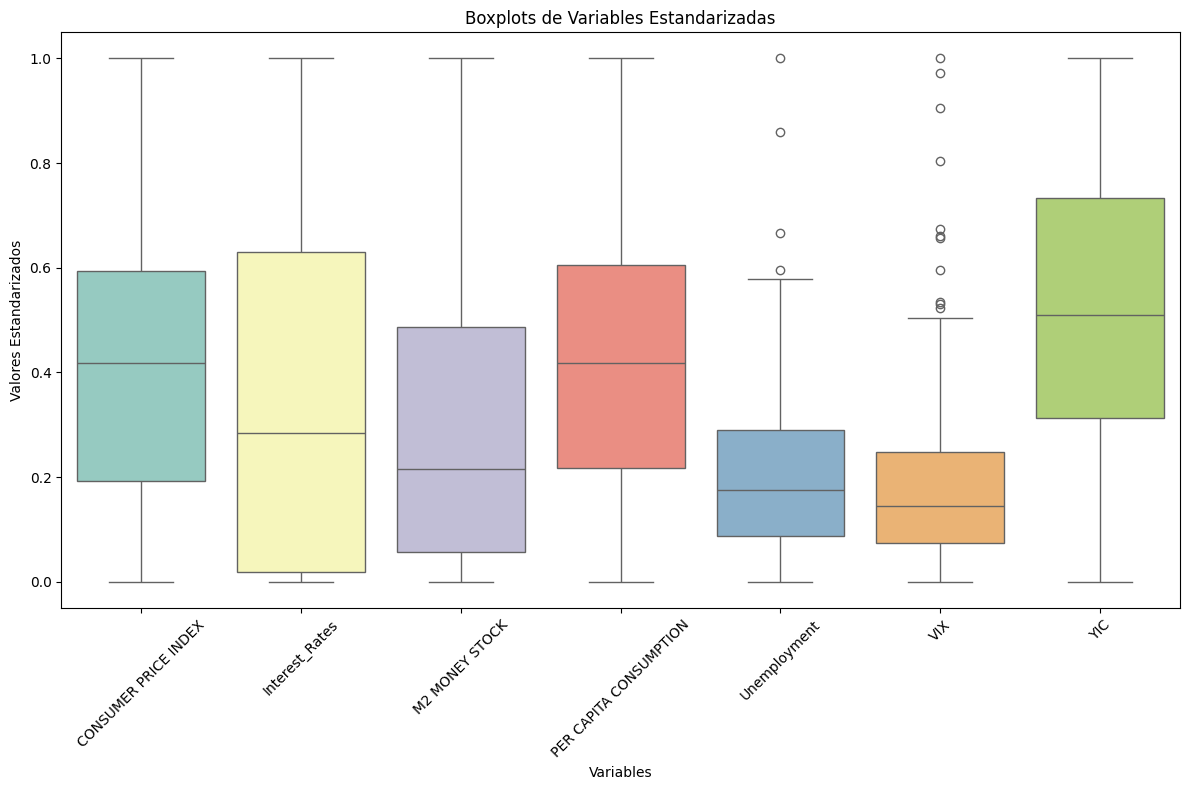

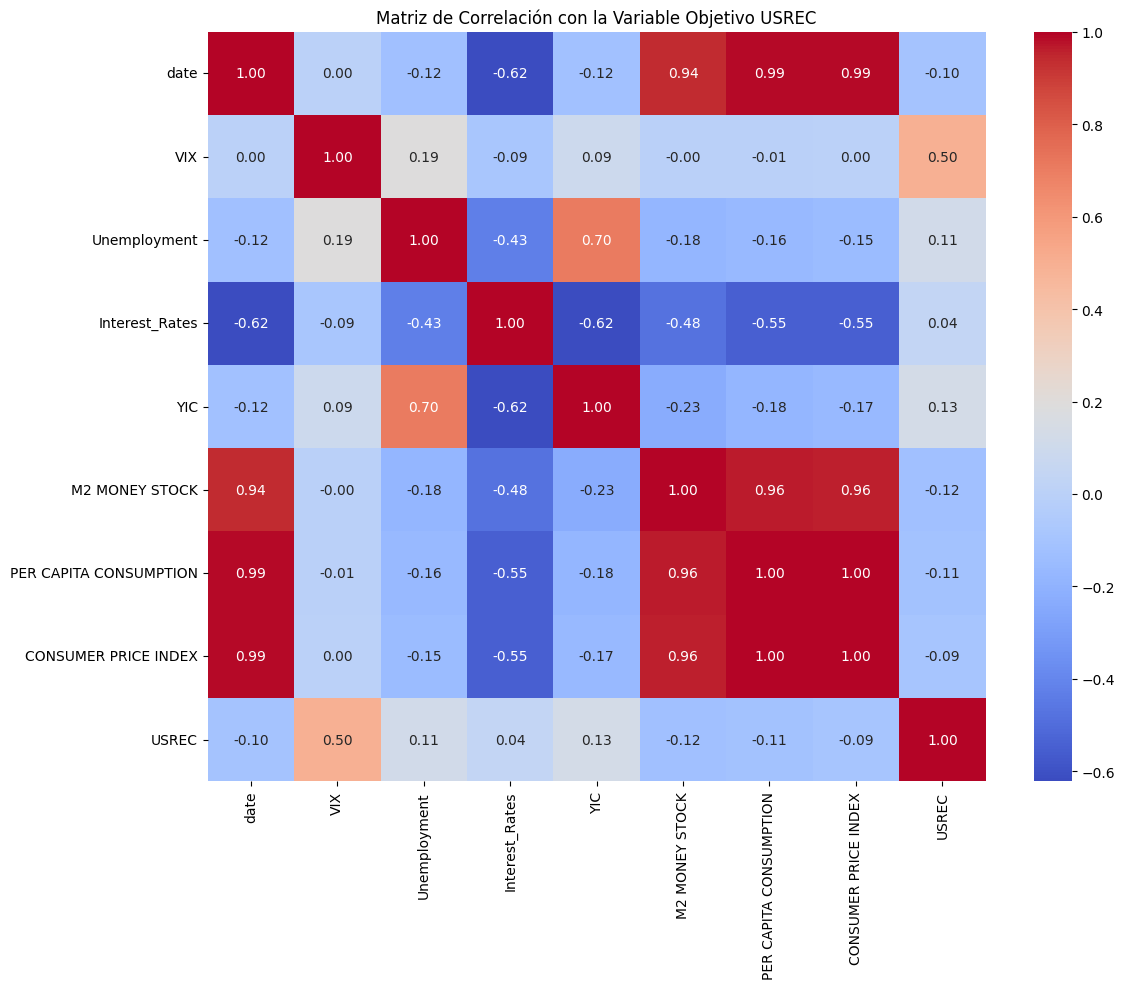

In [14]:

# Histogramas de las variables estandarizadas
plt.figure(figsize=(12, 8))
combined_df[columns_to_normalize].hist(bins=20, color='skyblue', edgecolor='black', linewidth=1.5)
plt.title('Histogramas de Variables Estandarizadas')
plt.xlabel('Valores Estandarizados')
plt.ylabel('Frecuencia')
plt.tight_layout()
plt.show()

# Boxplots de las variables estandarizadas
plt.figure(figsize=(12, 8))
sns.boxplot(data=combined_df[columns_to_normalize], palette='Set3')
plt.title('Boxplots de Variables Estandarizadas')
plt.xlabel('Variables')
plt.ylabel('Valores Estandarizados')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Matriz de correlación con la variable objetivo 'USREC'
plt.figure(figsize=(12, 10))
correlation_matrix = combined_df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matriz de Correlación con la Variable Objetivo USREC')
plt.tight_layout()
plt.show()


In [15]:
def rf_model(X_train, y_train, X_test, y_test):

    # Definir los parámetros para la búsqueda de hiperparámetros
    param_grid = {
        'n_estimators': [50, 100, 150],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }

    # Configurar el estimador
    rf_regressor = RandomForestRegressor(random_state=42)

    # Realizar la búsqueda de hiperparámetros utilizando GridSearchCV
    grid_search = GridSearchCV(estimator=rf_regressor, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')
    grid_search.fit(X_train, y_train)

    # Obtener el mejor modelo encontrado por la búsqueda de hiperparámetros
    best_rf_regressor = grid_search.best_estimator_

    # Obtener las importancias de las características
    feature_importances = best_rf_regressor.feature_importances_

    # Obtener nombres de las características
    feature_names = X_train.columns

    # Transformar a un diccionario {'variable': 'importancia'}
    feature_importance_dict = {feature_names[i]: importance for i, importance in enumerate(feature_importances)}

    # Realizar predicciones en el conjunto de prueba
    y_pred = best_rf_regressor.predict(X_test)

    # Calcular el error cuadrático medio
    mse = mean_squared_error(y_test, y_pred)
    print("Error cuadrático medio Random Forest:", mse)
    
    return y_pred, mse, best_rf_regressor, feature_importance_dict



def xgboost_model(X_train, y_train, X_test, y_test):

    # Definir los parámetros para la búsqueda de hiperparámetros
    param_grid = {
        'n_estimators': [50, 100, 150],
        'max_depth': [3, 4, 5],
        'learning_rate': [0.1, 0.01, 0.001],
        'min_child_weight': [1, 3, 5],
        'subsample': [0.8, 0.9, 1.0],
        'colsample_bytree': [0.8, 0.9, 1.0],
    }

    # Configurar el estimador
    xgb_regressor = XGBRegressor(objective='reg:squarederror', random_state=42)

    # Realizar la búsqueda de hiperparámetros utilizando GridSearchCV
    grid_search = GridSearchCV(estimator=xgb_regressor, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')
    grid_search.fit(X_train, y_train)

    # Obtener el mejor modelo encontrado por la búsqueda de hiperparámetros
    best_xgb_regressor = grid_search.best_estimator_

    # Obtener las importancias de las características
    feature_importances = best_xgb_regressor.feature_importances_

    # Obtener nombres de las características
    feature_names = X_train.columns

    # Transformar a un diccionario {'variable': 'importancia'}
    feature_importance_dict = {feature_names[i]: importance for i, importance in enumerate(feature_importances)}

    # Realizar predicciones en el conjunto de prueba
    y_pred = best_xgb_regressor.predict(X_test)

    # Calcular el error cuadrático medio
    mse = mean_squared_error(y_test, y_pred)
    print("Error cuadrático medio XGBoost:", mse)
    
    return y_pred, mse, best_xgb_regressor, feature_importance_dict

def lgbm_model(X_train, y_train, X_test, y_test):

    # Definir los parámetros para la búsqueda de hiperparámetros
    param_grid = {
        'n_estimators': [50, 100, 150],
        'max_depth': [3, 4, 5],
        'learning_rate': [0.1, 0.01, 0.001],
        'min_child_weight': [1, 3, 5],
        'subsample': [0.8, 0.9, 1.0],
        'colsample_bytree': [0.8, 0.9, 1.0],
    }

    # Configurar el estimador
    lgb_regressor = lgb.LGBMRegressor(objective='regression', random_state=42)

    # Realizar la búsqueda de hiperparámetros utilizando GridSearchCV
    grid_search = GridSearchCV(estimator=lgb_regressor, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')
    grid_search.fit(X_train, y_train)

    # Obtener el mejor modelo encontrado por la búsqueda de hiperparámetros
    best_lgb_regressor = grid_search.best_estimator_

    # Obtener las importancias de las características
    feature_importances = best_lgb_regressor.feature_importances_

    # Obtener nombres de las características
    feature_names = X_train.columns

    # Transformar a un diccionario {'variable': 'importancia'}
    feature_importance_dict = {feature_names[i]: importance for i, importance in enumerate(feature_importances)}

    # Realizar predicciones en el conjunto de prueba
    y_pred = best_lgb_regressor.predict(X_test)

    # Calcular el error cuadrático medio
    mse = mean_squared_error(y_test, y_pred)
    print("Error cuadrático medio LightGBM:", mse)
    
    return y_pred, mse, best_lgb_regressor, feature_importance_dict



def catboost_model(X_train, y_train, X_test, y_test):

        # Definir los parámetros para la búsqueda de hiperparámetros para CatBoost
    param_grid = {
        'iterations': [100, 200, 300],  # Número de iteraciones (árboles)
        'learning_rate': [0.01, 0.05, 0.1],  # Tasa de aprendizaje
        'depth': [4, 6, 8],  # Profundidad máxima del árbol
        'l2_leaf_reg': [1, 3, 5],  # Regularización L2
    }

    # Configurar el GridSearchCV con CatBoostRegressor
    grid_search = GridSearchCV(
        estimator=CatBoostRegressor(),
        param_grid=param_grid,
        cv=5,
        scoring='neg_mean_squared_error',
        n_jobs=-1  # Utilizar todos los núcleos disponibles
    )

    # Realizar la búsqueda de hiperparámetros
    grid_search.fit(X_train, y_train, cat_features=None, verbose=False)

    # Obtener el mejor modelo encontrado por la búsqueda de hiperparámetros
    best_catboost_regressor = grid_search.best_estimator_

    # Obtener importancias de características
    feature_importances = best_catboost_regressor.get_feature_importance()

    # Crear diccionario de importancias de características
    feature_importance_dict = {feature: importance for feature, importance in zip(X_train.columns, feature_importances)}

    # Realizar predicciones en el conjunto de prueba
    y_pred = best_catboost_regressor.predict(X_test)

    # Calcular el error cuadrático medio
    mse = mean_squared_error(y_test, y_pred)

    print("Error cuadrático medio CatBoost:", mse)
    # Devolver también las feature importances junto con las otras métricas
    return y_pred, mse, best_catboost_regressor, feature_importance_dict

In [16]:
combined1, combined2 = train_test_split(combined_df, test_size=0.2, random_state=42)

X = combined1.drop(['USREC','date'], axis=1)
y = combined1['USREC']

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [17]:
combined_df.shape

(413, 9)

In [18]:
print(f'train shape: {combined1.shape}')
print(f'test shape: {combined2.shape}')

train shape: (330, 9)
test shape: (83, 9)


In [19]:
rf_pred = rf_model(X_train,y_train,X_test,y_test)
xgboost_pred = xgboost_model(X_train,y_train,X_test,y_test)
catboost_pred = catboost_model(X_train,y_train,X_test,y_test)

Error cuadrático medio Random Forest: 0.02427205387205387
Error cuadrático medio XGBoost: 0.015870318295453774
Error cuadrático medio CatBoost: 0.015327489948598063


Guardamos el mejor modelo para cada caso

In [20]:
best_rf_regressor = rf_pred[2]
best_xgboost_regressor = xgboost_pred[2]
best_catboost_regressor = catboost_pred[2]

In [21]:
variables_rendimiento_rf = rf_pred[3]
variables_rendimiento_xgb = xgboost_pred[3]
variables_rendimiento_catboost = catboost_pred[3]


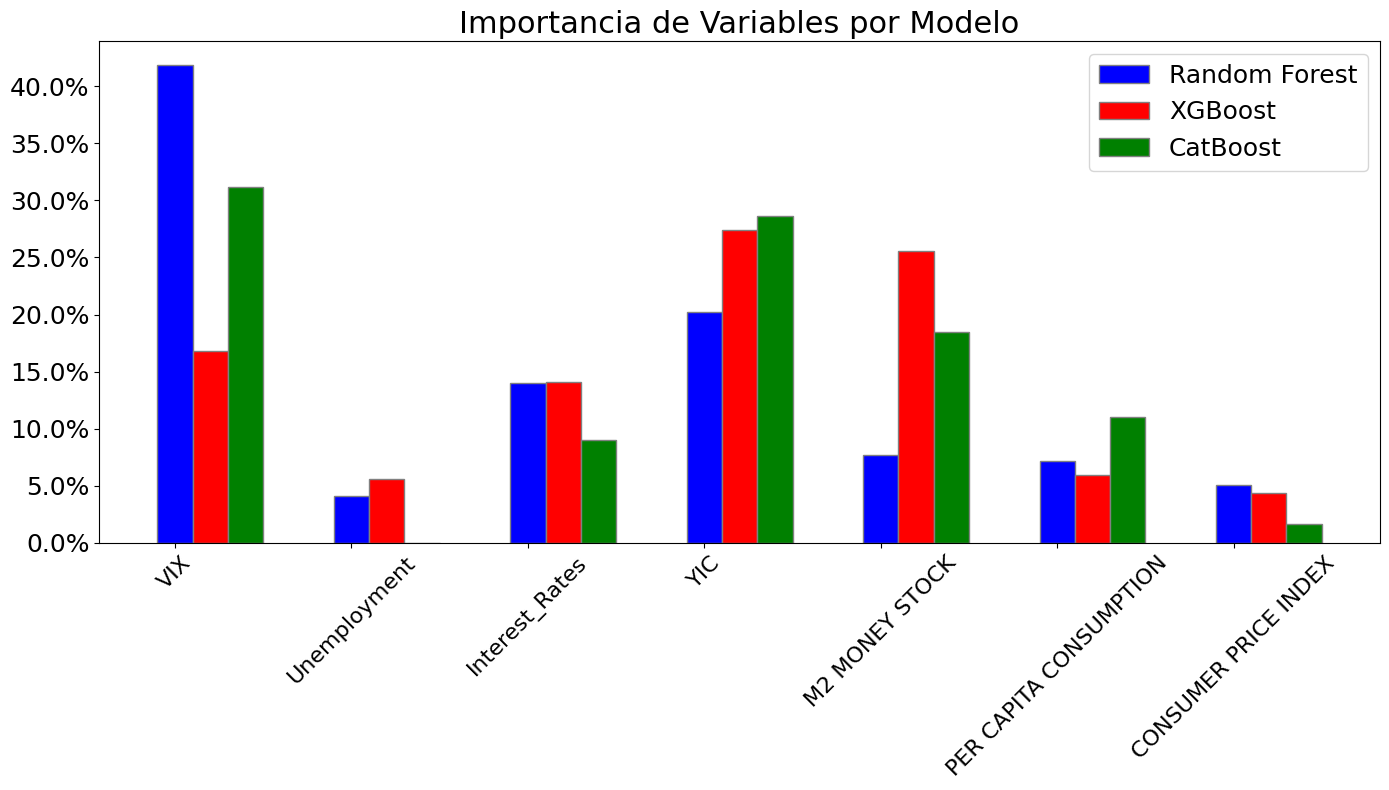

In [22]:
from matplotlib.ticker import PercentFormatter

# Crear DataFrames a partir de los diccionarios
df_rf = pd.DataFrame(list(variables_rendimiento_rf.items()), columns=['Variable', 'Importancia_RF'])
df_xgb = pd.DataFrame(list(variables_rendimiento_xgb.items()), columns=['Variable', 'Importancia_XGB'])
df_catboost = pd.DataFrame(list(variables_rendimiento_catboost.items()), columns=['Variable', 'Coeficiente_catboost'])

# Normalizar los coeficientes de catboost y LGBM entre 0 y 1
scaler = MinMaxScaler()
df_catboost['Coeficiente_catboost'] = scaler.fit_transform(df_catboost[['Coeficiente_catboost']])

# Unir los DataFrames en uno solo
df = df_rf.merge(df_xgb, on='Variable').merge(df_catboost, on='Variable')

df['Coeficiente_catboost'] = df['Coeficiente_catboost']/df['Coeficiente_catboost'].sum()

df['Coeficiente_catboost'] = df['Coeficiente_catboost']*100
df['Importancia_RF'] = df['Importancia_RF']*100
df['Importancia_XGB'] = df['Importancia_XGB']*100

# Configuración del gráfico
fig, ax = plt.subplots(figsize=(14, 8))

# Establecer el ancho de las barras
bar_width = 0.2

# Posiciones en el eje x
r1 = range(len(df))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]
r4 = [x + bar_width for x in r3]

# Crear las barras
ax.bar(r1, df['Importancia_RF'], color='b', width=bar_width, edgecolor='grey', label='Random Forest')
ax.bar(r2, df['Importancia_XGB'], color='r', width=bar_width, edgecolor='grey', label='XGBoost')
ax.bar(r3, df['Coeficiente_catboost'], color='g', width=bar_width, edgecolor='grey', label='CatBoost')

# Agregar etiquetas y título
ax.set_title('Importancia de Variables por Modelo', fontsize = 22)
ax.set_xticks([r for r in range(len(df))])

ax.set_xticklabels(df['Variable'], fontsize = 16, rotation = 45)

ax.yaxis.set_major_formatter(PercentFormatter())
ax.tick_params(axis='y', labelsize=18) 

# Añadir la leyenda
ax.legend(fontsize = 18)

# Mostrar el gráfico
plt.tight_layout()
plt.show()


In [23]:
df.sum()

Variable                VIXUnemploymentInterest_RatesYICM2 MONEY STOCK...
Importancia_RF                                                      100.0
Importancia_XGB                                                 99.999992
Coeficiente_catboost                                                100.0
dtype: object

In [24]:
# Guardar cada modelo en un fichero
joblib.dump(best_rf_regressor, 'best_rf_regressor.pkl')
joblib.dump(best_xgboost_regressor, 'best_xgboost_regressor.pkl')
joblib.dump(best_catboost_regressor, 'best_catboost_regressor.pkl')


['best_catboost_regressor.pkl']

Factores de penalización para ponderar las probabilidad final predicha por cada modelo

In [25]:
total_mse = rf_pred[1] + xgboost_pred[1] + catboost_pred[1]

factor_rf = rf_pred[1] 
factor_xgboost = xgboost_pred[1]  
factor_catboost = catboost_pred[1]  

In [26]:
print(f'Factor random forest {factor_rf}')
print(f'Factor XG Boost {factor_xgboost}')
print(f'Factor Catboost {factor_catboost}')


factor_catboost+factor_rf+factor_xgboost

Factor random forest 0.02427205387205387
Factor XG Boost 0.015870318295453774
Factor Catboost 0.015327489948598063


0.0554698621161057

GUARDO LOS FACTORES DE PENALIZACIÓN PARA USARLOS EN LA PREdICCIÓN

In [27]:
with open('factores.txt', 'w') as factores:
    factores.write(f'{factor_rf}\n')
    factores.write(f'{factor_catboost}\n')
    factores.write(f'{factor_xgboost}\n')
    factores.write(f'{total_mse}')

In [28]:
x_real = combined2.drop(['USREC','date'], axis = 1)
y_real, y_date = combined2['USREC'], combined2['date']

rf_test_pred = best_rf_regressor.predict(x_real)
xgboost_test_pred = best_xgboost_regressor.predict(x_real)
catboost_test_pred = best_catboost_regressor.predict(x_real)


In [29]:
combined2['date1'] = pd.to_datetime(combined2['date'], unit='ns')

predictions = pd.DataFrame()
predictions['Date'] = combined2['date1'].dt.strftime('%d-%m-%Y')
predictions['Original'] = combined2['USREC']
predictions['Random Forest'] = rf_test_pred
predictions['XG Boost'] = xgboost_test_pred
predictions['Catboost'] = catboost_test_pred


scaler = MinMaxScaler()

# Seleccionar las columnas a normalizar
columns_to_normalize = ['Random Forest', 'XG Boost', 'Catboost']

# Aplicar la normalización solo a las columnas seleccionadas
predictions[columns_to_normalize] = scaler.fit_transform(predictions[columns_to_normalize])



predictions['Probabilidad ponderada'] = (((predictions['Random Forest']/factor_rf) + (predictions['XG Boost']/factor_xgboost) + (predictions['Catboost']/factor_catboost) )* total_mse).round(2)

column_to_normalize = 'Probabilidad ponderada'
min_value = predictions[column_to_normalize].min()
max_value = predictions[column_to_normalize].max()

predictions[column_to_normalize] = (predictions[column_to_normalize] - min_value) / (max_value - min_value)


# Aplicar el escalado Min-Max a la columna 'probabilidad'
predictions['Probabilidad ponderada'] = predictions['Probabilidad ponderada']*100

In [30]:
predictions['Date'] = pd.to_datetime(predictions['Date'])
predictions = predictions.sort_values(by='Date')

In [31]:
predictions.to_excel('predictions.xlsx')

In [32]:
def asignar_valor(valor):
    if valor > 50:
        print('Mayor a 50')
        return 1
    else:
        return 0

# Aplicar la función a la columna 'Probabilidad ponderada' para crear una nueva columna 'Nueva columna'
predictions['Clasificacion'] = predictions['Probabilidad ponderada'].apply(lambda x: asignar_valor(x))

Mayor a 50
Mayor a 50
Mayor a 50
Mayor a 50


In [33]:
predictions['Clasificacion_RF'] = predictions['Random Forest'].apply(lambda x: asignar_valor(x*100))
predictions['Clasificacion_XGBoost'] = predictions['XG Boost'].apply(lambda x: asignar_valor(x*100))
predictions['Clasificacion_catboost'] = predictions['Catboost'].apply(lambda x: asignar_valor(x*100))


Mayor a 50
Mayor a 50
Mayor a 50
Mayor a 50
Mayor a 50
Mayor a 50
Mayor a 50
Mayor a 50
Mayor a 50
Mayor a 50
Mayor a 50
Mayor a 50
Mayor a 50


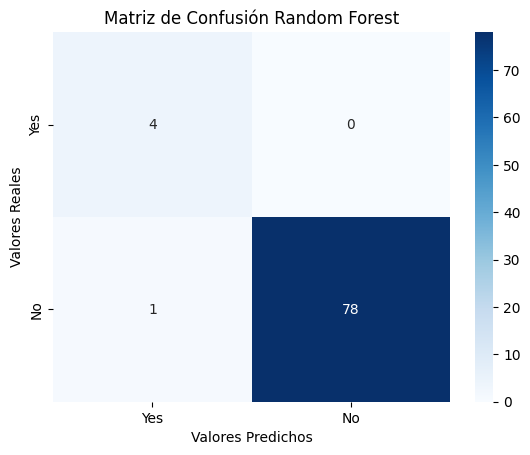

Precisión (Accuracy): 0.9879518072289156
Ratio de verdaderos positivos (Recall): 1.0


In [34]:
y_true = predictions['Original']  # Valores reales
y_pred = predictions['Clasificacion_RF']  # Valores predichos

# Calcular la matriz de confusión
conf_matrix = confusion_matrix(y_true, y_pred)

# Definir el orden de las etiquetas
labels = ['Yes', 'No']

# Reordenar la matriz de confusión según el nuevo orden de etiquetas
conf_matrix = conf_matrix[[1, 0], :]  # Filas: 'Yes' primero, 'No' segundo
conf_matrix = conf_matrix[:, [1, 0]]  # Columnas: 'Yes' primero, 'No' segundo

# Crear un mapa de calor de la matriz de confusión
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g', xticklabels=labels, yticklabels=labels)

# Configurar etiquetas y título
plt.xlabel('Valores Predichos')
plt.ylabel('Valores Reales')
plt.title('Matriz de Confusión Random Forest')

# Mostrar el mapa de calor
plt.show()

# Calcular precisión (accuracy)
accuracy_rf = (conf_matrix[0, 0] + conf_matrix[1, 1]) / conf_matrix.sum()

# Calcular ratio de verdaderos positivos (Recall)
true_positives = conf_matrix[0, 0]  # Verdaderos positivos para 'Yes'
total_actual_positives = sum(y_true)  # Total de valores '1' reales
ratio_rf = true_positives / total_actual_positives if total_actual_positives != 0 else 0

print("Precisión (Accuracy):", accuracy_rf)
print("Ratio de verdaderos positivos (Recall):", ratio_rf)

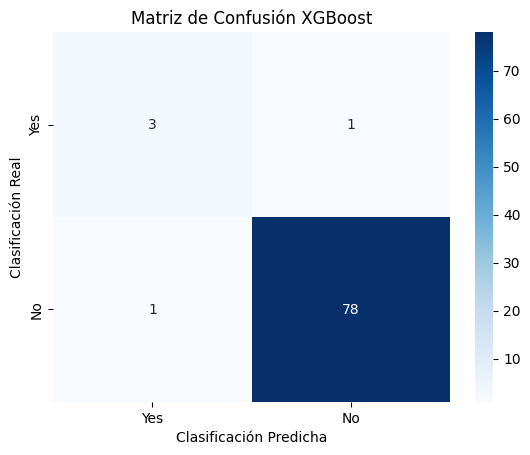

Precisión (Accuracy): 0.9759036144578314
Ratio de verdaderos positivos (Recall): 0.75


In [35]:
y_true = predictions['Original']  # Valores reales
y_pred = predictions['Clasificacion_XGBoost']  # Valores predichos

# Calcular la matriz de confusión
conf_matrix = confusion_matrix(y_true, y_pred)

# Definir el orden de las etiquetas
labels = ['Yes', 'No']

# Reordenar la matriz de confusión según el nuevo orden de etiquetas
conf_matrix = conf_matrix[[1, 0], :]  # Filas: 'Yes' primero, 'No' segundo
conf_matrix = conf_matrix[:, [1, 0]]  # Columnas: 'Yes' primero, 'No' segundo

# Crear un mapa de calor de la matriz de confusión
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g', xticklabels=labels, yticklabels=labels)

# Configurar etiquetas y título
plt.xlabel('Clasificación Predicha')
plt.ylabel('Clasificación Real')
plt.title('Matriz de Confusión XGBoost')

# Mostrar el mapa de calor
plt.show()

# Calcular precisión (accuracy)
accuracy_xgb = (conf_matrix[0, 0] + conf_matrix[1, 1]) / conf_matrix.sum()

# Calcular ratio de verdaderos positivos (Recall)
true_positives = conf_matrix[0, 0]  # Verdaderos positivos para 'Yes'
total_actual_positives = sum(y_true)  # Total de valores '1' reales
ratio_xgb = true_positives / total_actual_positives if total_actual_positives != 0 else 0

print("Precisión (Accuracy):", accuracy_xgb)
print("Ratio de verdaderos positivos (Recall):", ratio_xgb)

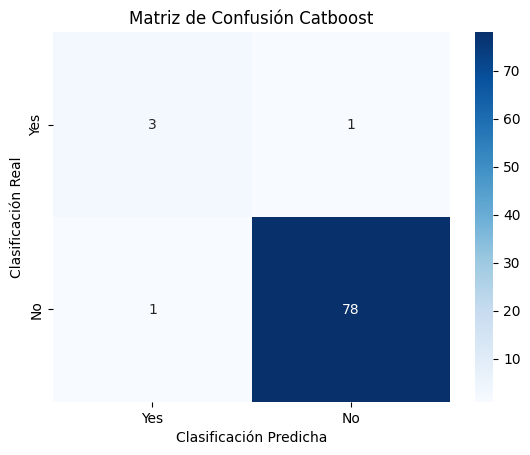

Precisión (Accuracy): 0.9759036144578314
Ratio de verdaderos positivos (Recall): 0.75


In [36]:
y_true = predictions['Original']  # Valores reales
y_pred = predictions['Clasificacion_catboost']  # Valores predichos

# Calcular la matriz de confusión
conf_matrix = confusion_matrix(y_true, y_pred)

# Definir el orden de las etiquetas
labels = ['Yes', 'No']

# Reordenar la matriz de confusión según el nuevo orden de etiquetas
conf_matrix = conf_matrix[[1, 0], :]  # Filas: 'Yes' primero, 'No' segundo
conf_matrix = conf_matrix[:, [1, 0]]  # Columnas: 'Yes' primero, 'No' segundo

# Crear un mapa de calor de la matriz de confusión
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g', xticklabels=labels, yticklabels=labels)

# Configurar etiquetas y título
plt.xlabel('Clasificación Predicha')
plt.ylabel('Clasificación Real')
plt.title('Matriz de Confusión Catboost')

# Mostrar el mapa de calor
plt.show()

# Calcular precisión (accuracy)
accuracy_catboost = (conf_matrix[0, 0] + conf_matrix[1, 1]) / conf_matrix.sum()

# Calcular ratio de verdaderos positivos (Recall)
true_positives = conf_matrix[0, 0]  # Verdaderos positivos para 'Yes'
total_actual_positives = sum(y_true)  # Total de valores '1' reales
ratio_catboost = true_positives / total_actual_positives if total_actual_positives != 0 else 0

print("Precisión (Accuracy):", accuracy_catboost)
print("Ratio de verdaderos positivos (Recall):", ratio_catboost)


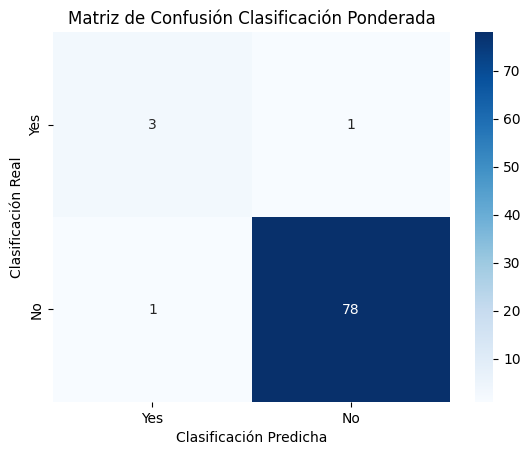

Precisión (Accuracy): 0.9759036144578314
Ratio de verdaderos positivos (Recall): 0.75


In [37]:

y_true = predictions['Original']  # Valores reales
y_pred = predictions['Clasificacion']  # Valores predichos

# Calcular la matriz de confusión
conf_matrix = confusion_matrix(y_true, y_pred)

# Definir el orden de las etiquetas 
labels = ['Yes', 'No']

# Reordenar la matriz de confusión según el nuevo orden de etiquetas
conf_matrix = conf_matrix[[1, 0], :]  # Filas: 'Yes' primero, 'No' segundo
conf_matrix = conf_matrix[:, [1, 0]]  # Columnas: 'Yes' primero, 'No' segundo

# Crear un mapa de calor de la matriz de confusión
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g', xticklabels=labels, yticklabels=labels)

# Configurar etiquetas y título
plt.xlabel('Clasificación Predicha')
plt.ylabel('Clasificación Real')
plt.title('Matriz de Confusión Clasificación Ponderada')

# Mostrar el mapa de calor
plt.show()

# Calcular precisión (accuracy)
accuracy = (conf_matrix[0, 0] + conf_matrix[1, 1]) / conf_matrix.sum()

# Calcular ratio de verdaderos positivos (Recall)
true_positives = conf_matrix[0, 0]  # Verdaderos positivos para 'Yes'
total_actual_positives = sum(y_true)  # Total de valores '1' reales
ratio = true_positives / total_actual_positives if total_actual_positives != 0 else 0

print("Precisión (Accuracy):", accuracy)
print("Ratio de verdaderos positivos (Recall):", ratio)

In [38]:
columns_to_keep = ['Original', 'Clasificacion_RF', 'Clasificacion_XGBoost', 'Clasificacion_catboost', 'Clasificacion','Date']
filtered_df = predictions.loc[predictions['Original'] == 1]

filtered_df = filtered_df[columns_to_keep]

In [39]:
filtered_df

,Original,Clasificacion_RF,Clasificacion_XGBoost,Clasificacion_catboost,Clasificacion,Date
9,1.0,1,1,1,1,1990-01-10
137,1.0,1,1,1,1,2001-01-06
141,1.0,1,1,1,1,2001-01-10
362,1.0,1,0,0,0,2020-01-03


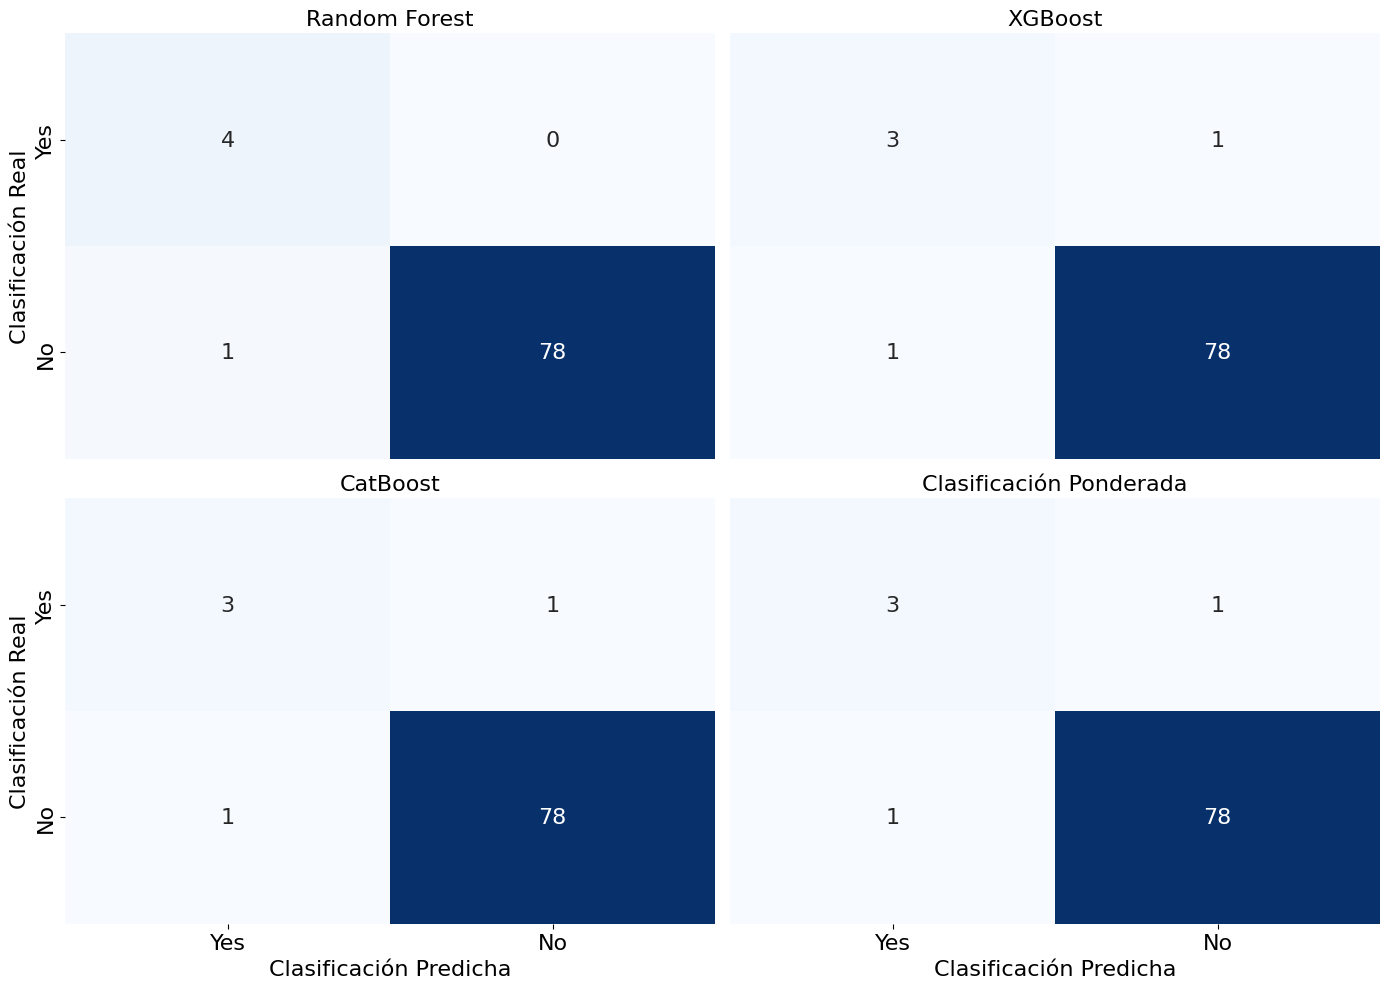

Random Forest Metrics:
Precisión (Accuracy): 0.9879518072289156
Ratio de verdaderos positivos (Recall): 1.0

XGBoost Metrics:
Precisión (Accuracy): 0.9759036144578314
Ratio de verdaderos positivos (Recall): 0.75

CatBoost Metrics:
Precisión (Accuracy): 0.9759036144578314
Ratio de verdaderos positivos (Recall): 0.75

Clasificación Ponderada Metrics:
Precisión (Accuracy): 0.9759036144578314
Ratio de verdaderos positivos (Recall): 0.75



In [40]:
y_true = predictions['Original']  # Valores reales

y_pred_rf = predictions['Clasificacion_RF']  # Valores predichos
y_pred_xgb = predictions['Clasificacion_XGBoost']  # Valores predichos
y_pred_catboost = predictions['Clasificacion_catboost']  # Valores predichos
y_pred_ponderado = predictions['Clasificacion']


# Función para calcular y reorganizar la matriz de confusión
def get_confusion_matrix(y_true, y_pred):
    conf_matrix = confusion_matrix(y_true, y_pred)
    conf_matrix = conf_matrix[[1, 0], :]  # Filas: 'Yes' primero, 'No' segundo
    conf_matrix = conf_matrix[:, [1, 0]]  # Columnas: 'Yes' primero, 'No' segundo
    return conf_matrix

# Calcular matrices de confusión para cada modelo
conf_matrix_rf = get_confusion_matrix(y_true, y_pred_rf)
conf_matrix_xgb = get_confusion_matrix(y_true, y_pred_xgb)
conf_matrix_catboost = get_confusion_matrix(y_true, y_pred_catboost)
conf_matrix_weighted = get_confusion_matrix(y_true, y_pred_ponderado)

# Definir el orden de las etiquetas
labels = ['Yes', 'No']

# Crear subplots 2x2
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Mapa de calor para Random Forest
sns.heatmap(conf_matrix_rf, annot=True, cmap='Blues', fmt='g', xticklabels=[], yticklabels=labels, ax=axes[0, 0], cbar=False, annot_kws={"size": 16})
axes[0, 0].set_xlabel('')
axes[0, 0].set_ylabel('Clasificación Real', fontsize = 16)
axes[0, 0].set_title('Random Forest', fontsize = 16)
axes[0, 0].tick_params(axis='both', which='major', labelsize=16)

# Mapa de calor para XGBoost
sns.heatmap(conf_matrix_xgb, annot=True, cmap='Blues', fmt='g', xticklabels=[], yticklabels=[], ax=axes[0, 1], cbar=False, annot_kws={"size": 16})
axes[0, 1].set_xlabel('')
axes[0, 1].set_ylabel('')
axes[0, 1].set_title('XGBoost', fontsize = 16)
axes[0, 1].tick_params(axis='both', which='major', labelsize=16)


# Mapa de calor para CatBoost
sns.heatmap(conf_matrix_catboost, annot=True, cmap='Blues', fmt='g', xticklabels=labels, yticklabels=labels, ax=axes[1, 0], cbar=False, annot_kws={"size": 16})
axes[1, 0].set_xlabel('Clasificación Predicha', fontsize = 16)
axes[1, 0].set_ylabel('Clasificación Real',fontsize = 16)
axes[1, 0].set_title('CatBoost', fontsize = 16)
axes[1, 0].tick_params(axis='both', which='major', labelsize=16)


# Mapa de calor para Clasificación Ponderada
sns.heatmap(conf_matrix_weighted, annot=True, cmap='Blues', fmt='g', xticklabels=labels, yticklabels=[], ax=axes[1, 1], cbar=False, annot_kws={"size": 16})
axes[1, 1].set_xlabel('Clasificación Predicha', fontsize = 16)
axes[1, 1].set_ylabel('')
axes[1, 1].set_title('Clasificación Ponderada', fontsize = 16)
axes[1, 1].tick_params(axis='both', which='major', labelsize=16)

# Ajustar diseño
plt.tight_layout()
plt.show()

# Calcular y mostrar métricas para cada modelo
def print_metrics(conf_matrix, model_name):
    accuracy = (conf_matrix[0, 0] + conf_matrix[1, 1]) / conf_matrix.sum()
    true_positives = conf_matrix[0, 0]  # Verdaderos positivos para 'Yes'
    total_actual_positives = sum(y_true)  # Total de valores '1' reales
    recall = true_positives / total_actual_positives if total_actual_positives != 0 else 0
    print(f"{model_name} Metrics:")
    print(f"Precisión (Accuracy): {accuracy}")
    print(f"Ratio de verdaderos positivos (Recall): {recall}\n")

print_metrics(conf_matrix_rf, "Random Forest")
print_metrics(conf_matrix_xgb, "XGBoost")
print_metrics(conf_matrix_catboost, "CatBoost")
print_metrics(conf_matrix_weighted, "Clasificación Ponderada")

In [ ]:
predictions.to_excel('predictions.xlsx')

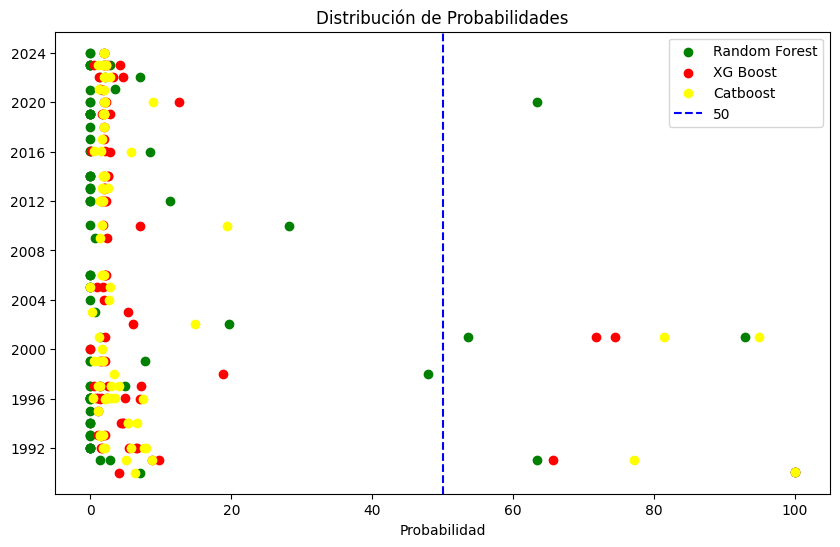

In [41]:
df_sorted = predictions.sort_values(by='Date')

# Crear un gráfico de dispersión
plt.figure(figsize=(10, 6))
plt.scatter(df_sorted['Random Forest']*100, df_sorted['Date'], color = 'green', label = 'Random Forest')
plt.scatter(df_sorted['XG Boost']*100, df_sorted['Date'], color = 'red', label = 'XG Boost')
plt.scatter(df_sorted['Catboost']*100, df_sorted['Date'], color = 'yellow', label = 'Catboost')



# Trazar una línea vertical en el punto 50 en el eje X
plt.axvline(x=50, color='b', linestyle='--', label='50')
plt.legend()
# Añadir etiquetas y leyenda
plt.xlabel('Probabilidad')
# plt.ylabel()
plt.title('Distribución de Probabilidades')
plt.legend()

# Mostrar el gráfico
plt.show()

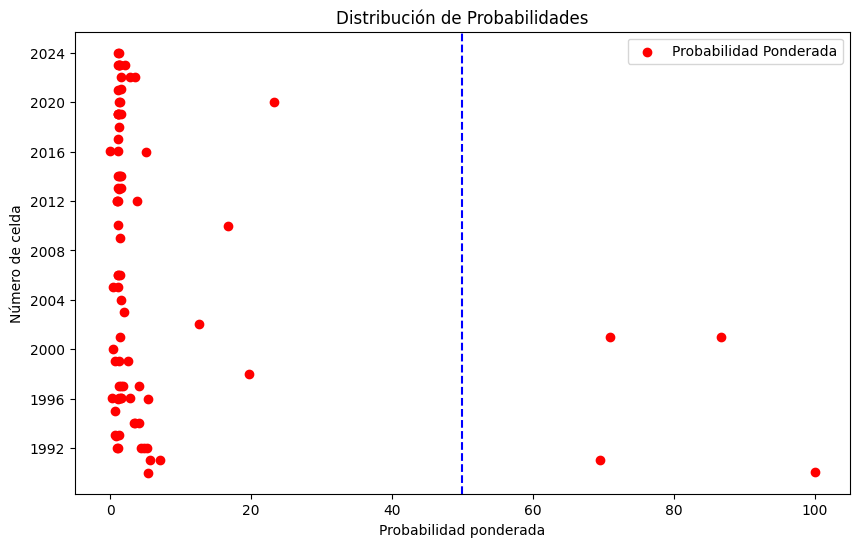

In [42]:
# Crear un gráfico de dispersión
plt.figure(figsize=(10, 6))
plt.scatter(df_sorted['Probabilidad ponderada'], df_sorted['Date'], color = 'red', label = 'Probabilidad Ponderada')

# Trazar una línea vertical en el punto 50 en el eje X
plt.axvline(x=50, color='b', linestyle='--')
plt.legend()
# Añadir etiquetas y leyenda
plt.xlabel('Probabilidad ponderada')
plt.ylabel('Número de celda')
plt.title('Distribución de Probabilidades')
plt.legend()

# Mostrar el gráfico
plt.show()